In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC, SVR
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [4]:
from ml_regression import train_and_evaluate_rf, train_and_evaluate_svr, train_and_evaluate_xgb, svr_grid_search, rf_grid_search

In [5]:
from ml_regression import tune_xgb_hyperparameters_random as tune_xgb

In [6]:
def calculate_cdf(series, num_points=1024):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [7]:
def load_dataset(files):
    data_arr = []
    for file_path in files:
        data_raw = pd.read_csv(file_path).values.astype(np.float32)
        if len(data_raw[:, 1]) == 0:
            print(f"Warning: No data in {file_path}")
            continue


        # data = np.expand_dims(data_raw[:, 1], axis=1)
        min_length = min(min_length, len(data_raw[:, 1]))
        cdf_features = calculate_cdf(data_raw[:, 1])        
        data_arr.append(cdf_features)
    
    return np.array(data_arr)

In [8]:
def load_files(files, max_len=None):
    data_arr = []
    
    for filepath in files:
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        # cdf = calculate_cdf(x)

        data_arr.append(x)
    
    return np.array(data_arr)

In [9]:
data_storage = {
    'Join': {
        'dirs': [
            './nexmark_dataset/q3_join/actual_data',
            './nexmark_dataset/q4_join_auction_bid/actual_data',
        ],
        'label': 2,
        'substring': 'process_time',
        'end_char': '.'
    },
    'Max_GroupBy': {
        'dirs': [
            './nexmark_dataset/q6_max',
            './nexmark_dataset/q4_max',
        ],
        'label': 3,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Sliding': {
        'dirs': [
            './nexmark_dataset/q4_avg',
        ],
        'label': 4,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Partition': {
        'dirs': [
            './nexmark_dataset/avg_partition',
        ],
        'label': 5,
        'substring': 'tail_0',
        'end_char': '_'
    },
    'Count_By_Auction': {
        'dirs': [
            './nexmark_dataset/q5_count_by_auction',
        ],
        'label': 6,
        'substring': 'tail_0',
        'end_char': '.'
    },
}

In [10]:
class_names = [
    'Join', 
    'Max_GroupBy', 
    'Avg_Sliding', 
    'Avg_Partition',
    'Count_By_Auction',
]

In [11]:
data_files = {}
for operator in data_storage:
    data_files[operator] = {
        'files': [],
        'label': data_storage[operator]['label'],
    }

    for dir in data_storage[operator]['dirs']:
        files = [f for f in os.listdir(dir) if f.endswith('.csv')]
        data_files[operator]['files'].extend([os.path.join(dir, file) for file in files])

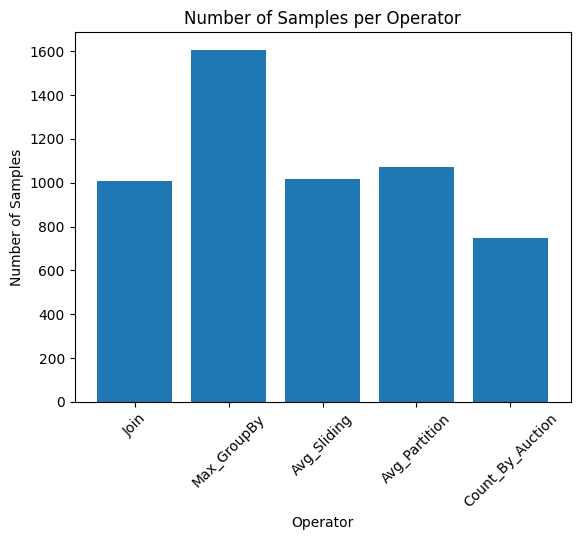

In [12]:
# Count the number of samples per operator
operator_counts = {operator: len(data_files[operator]['files']) for operator in data_files}

# Plot the data
plt.bar(operator_counts.keys(), operator_counts.values())
plt.xlabel('Operator')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Operator')
plt.xticks(rotation=45)
plt.show()

In [13]:
for operator in data_files:
    if operator == 'Join':
        data_files[operator]['train'] = data_files[operator]['files'][:504]
        data_files[operator]['test'] = data_files[operator]['files'][504:]
    elif operator == 'Map':
        data_files[operator]['train'] = data_files[operator]['files'][:494]
        data_files[operator]['test'] = data_files[operator]['files'][494:]
    elif operator == 'Filter':
        data_files[operator]['train'] = data_files[operator]['files'][:676]
        data_files[operator]['test'] = data_files[operator]['files'][676:]
    elif operator == 'Max_GroupBy':
        data_files[operator]['train'] = data_files[operator]['files'][:547]
        data_files[operator]['test'] = data_files[operator]['files'][1094:]
    else:
        train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
        data_files[operator]['train'] = train
        data_files[operator]['test'] = test
    # train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
    # data_files[operator]['train'] = train
    # data_files[operator]['test'] = test

    data_files[operator]['train_data'] = load_files(data_files[operator]['train'], 5000)
    data_files[operator]['test_data'] = load_files(data_files[operator]['test'], 5000)

    data_files[operator]['train_window_time'] = []
    data_files[operator]['train_sliding_step'] = []
    substring = data_storage[operator]['substring']
    end_char = data_storage[operator]['end_char']

    for file in data_files[operator]['train']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['train_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['train_sliding_step'].append(int(sliding_step))



    data_files[operator]['test_window_time'] = []
    data_files[operator]['test_sliding_step'] = []
    for file in data_files[operator]['test']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['test_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['test_sliding_step'].append(int(sliding_step))



In [13]:
data_files['Join']['train'][0]

'./nexmark_dataset/q3_join/actual_data/tail_0_0_process_time_4000_560.csv'

In [14]:
from ts2vec import TS2Vec

In [15]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'new_model_5000_1024.pkl')

In [18]:
def train_and_evaluate_ml_model(operator, variable_name, func, params):

    x_train = data_files[operator]['train_data']
    y_train = data_files[operator][f'train_{variable_name}']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator][f'test_{variable_name}']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
    
    train_embeddings = model.encode(x_train, encoding_window='full_series')
    test_embeddings = model.encode(x_test, encoding_window='full_series')

    return func(train_embeddings, y_train, test_embeddings, y_test, **params)

Training Random Forest for Join...
(504, 5000, 1) (504,) (505, 5000, 1) (505,)
Mean Squared Error (MSE): 1260.0950
R² Score: 0.9395


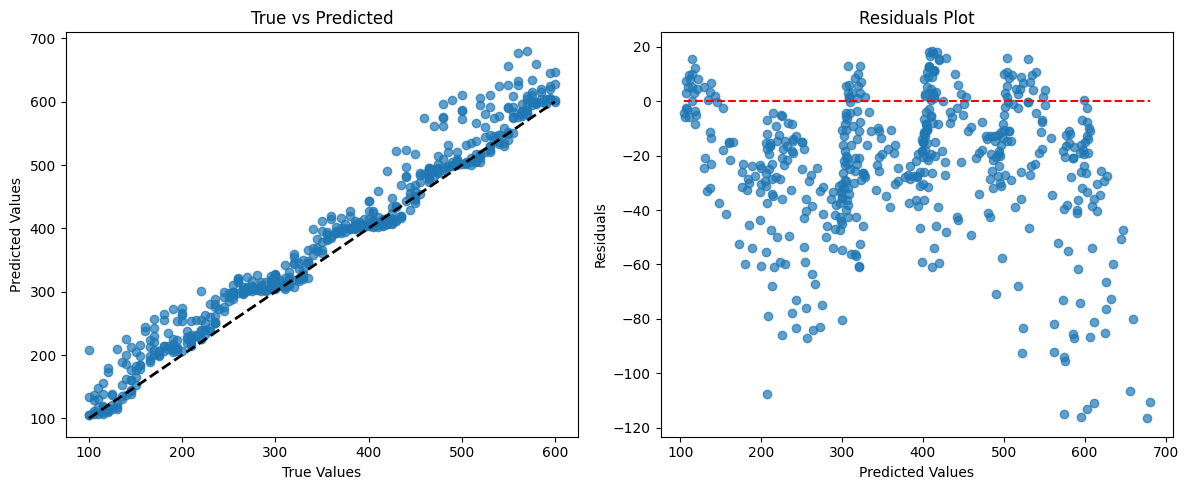

Training Random Forest for Max_GroupBy...
(547, 5000, 1) (547,) (512, 5000, 1) (512,)
Mean Squared Error (MSE): 1327632.6880
R² Score: 0.3531


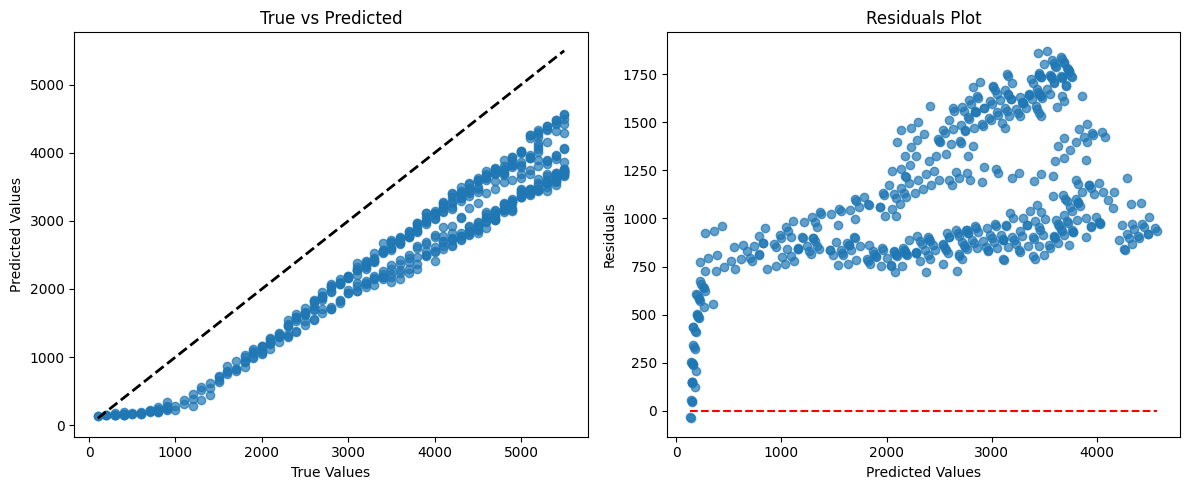

Training Random Forest for Avg_Sliding...
(509, 5000, 1) (509,) (509, 5000, 1) (509,)
Mean Squared Error (MSE): 22532.3703
R² Score: 0.9936


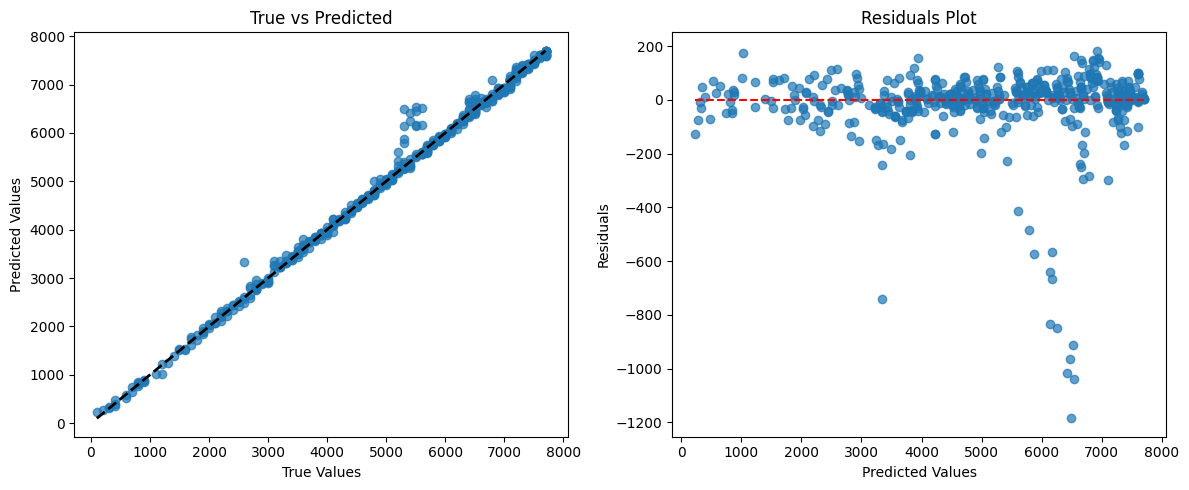

Training Random Forest for Avg_Partition...
(535, 5000, 1) (535,) (536, 5000, 1) (536,)
Mean Squared Error (MSE): 111861.0905
R² Score: 0.8403


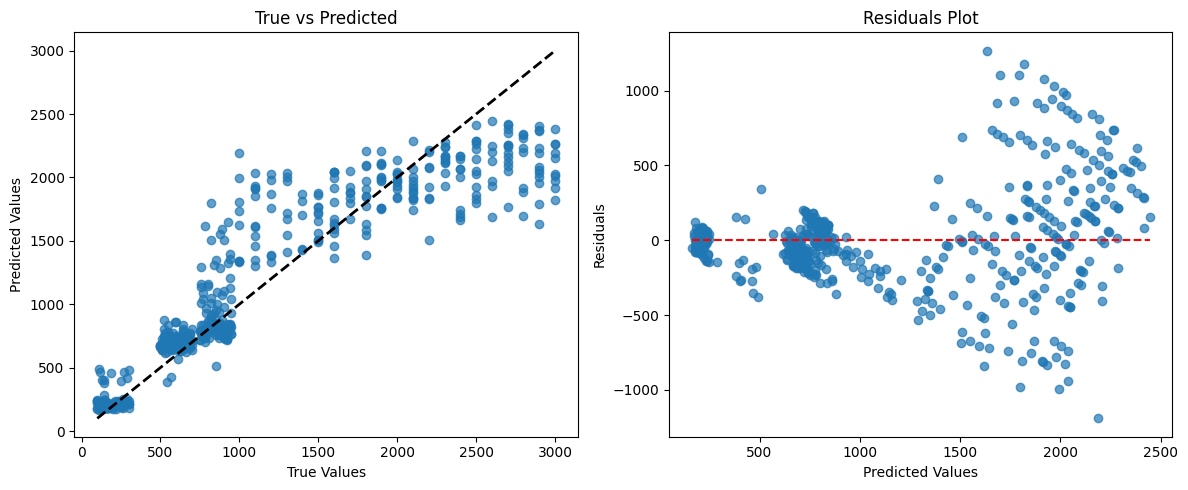

Training Random Forest for Count_By_Auction...
(375, 5000, 1) (375,) (375, 5000, 1) (375,)
Mean Squared Error (MSE): 29.2318
R² Score: 0.9838


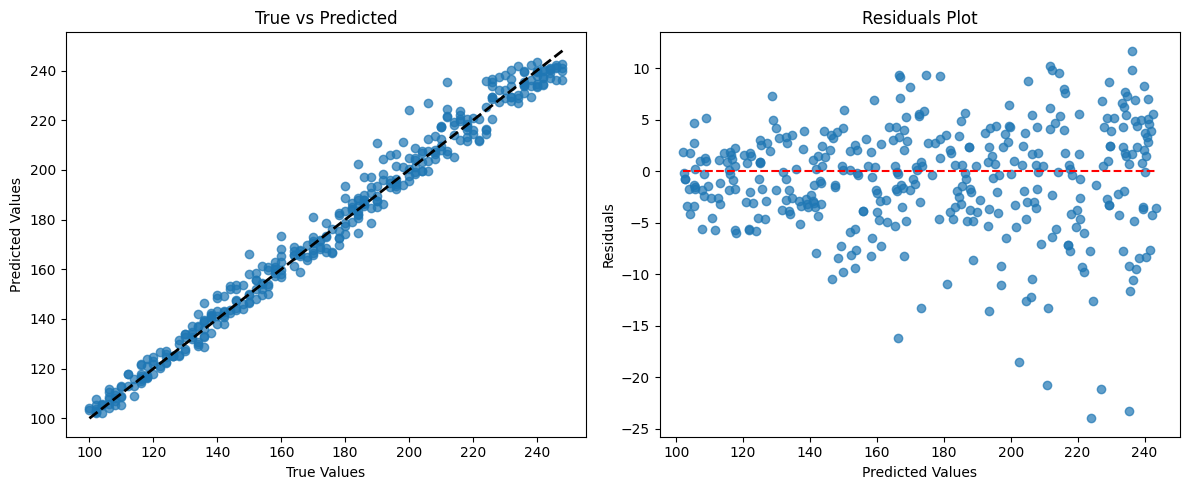

In [21]:
rf_window_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_window_models[operator] = train_and_evaluate_ml_model(operator, 'window_time', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

In [ ]:
rf_sliding_step_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_sliding_step_models[operator] = train_and_evaluate_ml_model(operator, 'sliding_step', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

Training SVR for Join...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.3s
[CV] END bootstrap=True, max_depth=None,

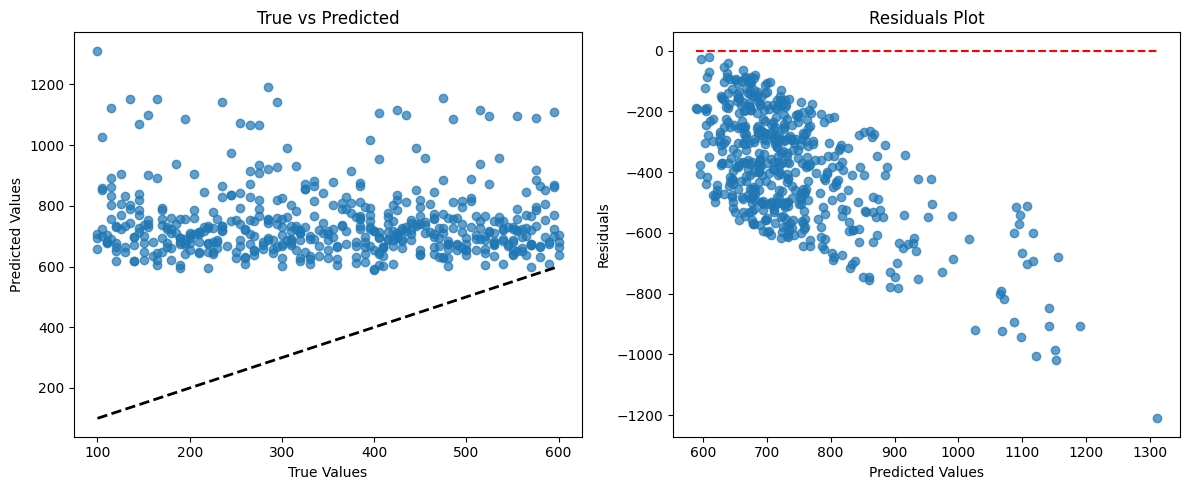

Training SVR for Max_GroupBy...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   4.9s
[CV] END bootstrap=True, max_dept

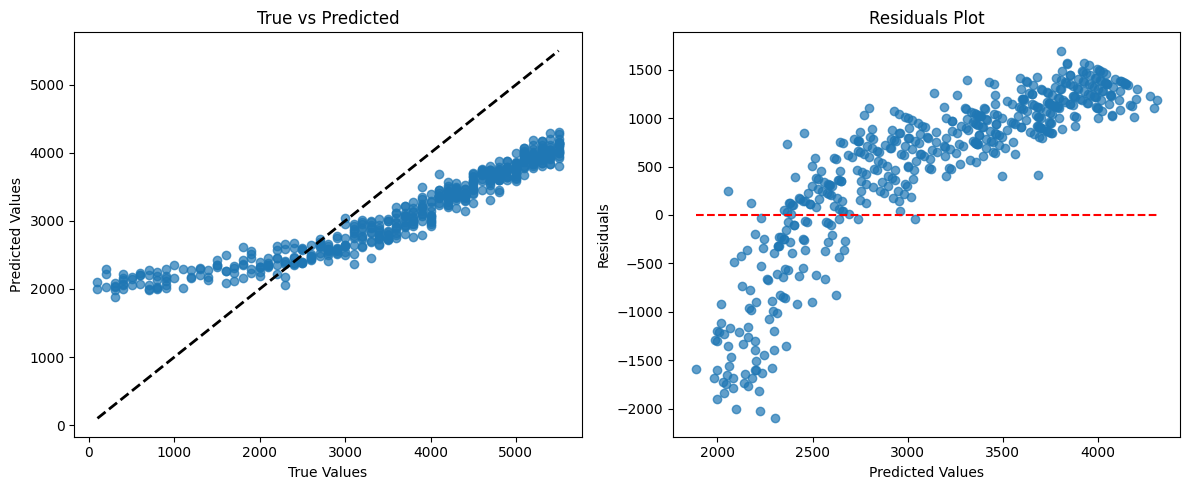

Training SVR for Avg_Sliding...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   2.9s
[CV] END bootstrap=True, max_dept

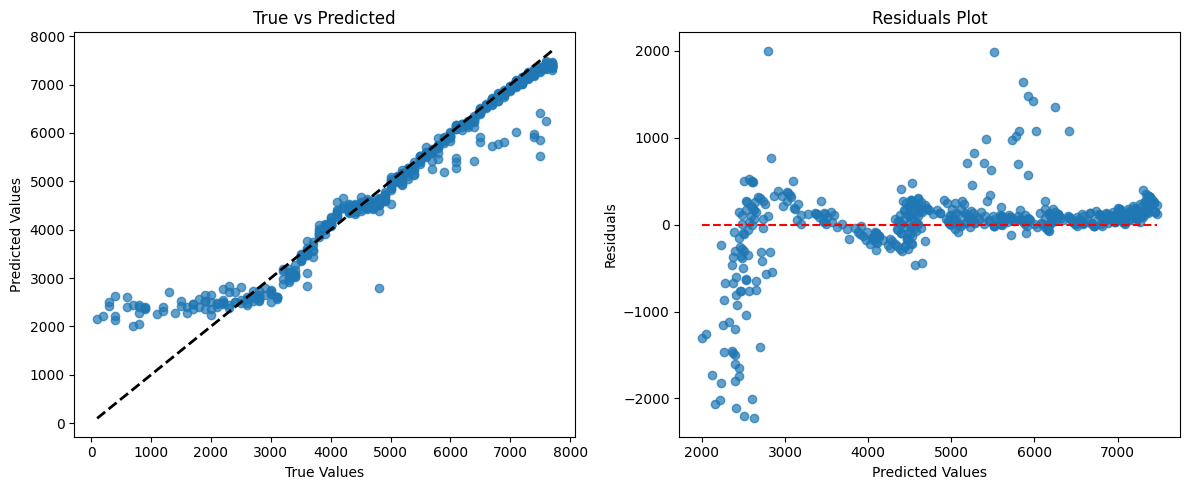

Training SVR for Avg_Partition...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   3.5s
[CV] END bootstrap=True, max_de

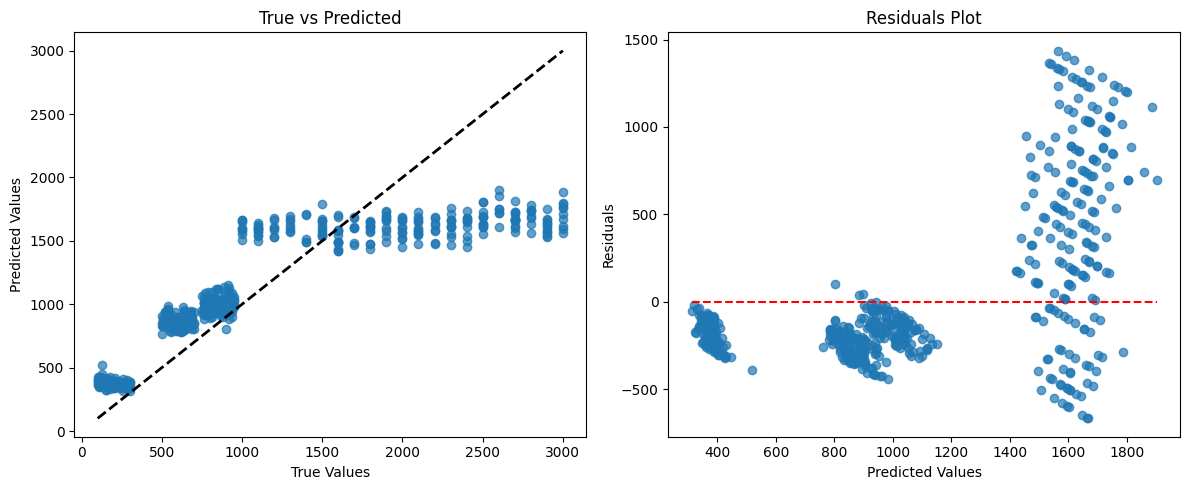

Training SVR for Count_By_Auction...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.9s
[CV] END bootstrap=True, max

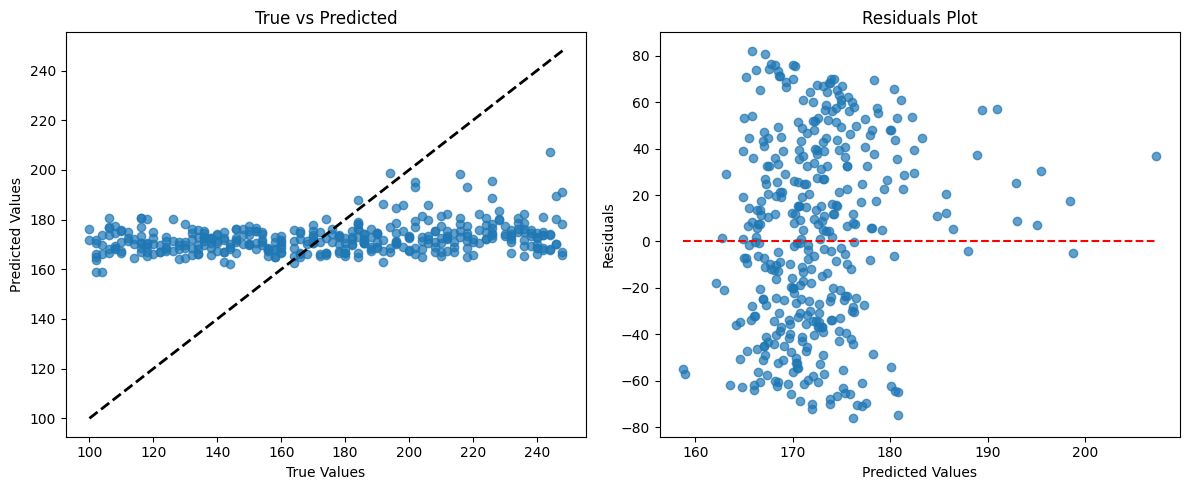

In [20]:
rf_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    rf_window_models[operator] = {
        'model': None,
        'params': None,
    }
    rf_window_models[operator]['model'], 
    rf_window_models[operator]['params'] = rf_grid_search(x_train, y_train, x_test, y_test)

Training SVR for join...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto'}
Best cross-validation score: 0.9433913714012631
Mean Squared Error (MSE): 147587.3358
R² Score: 0.9277


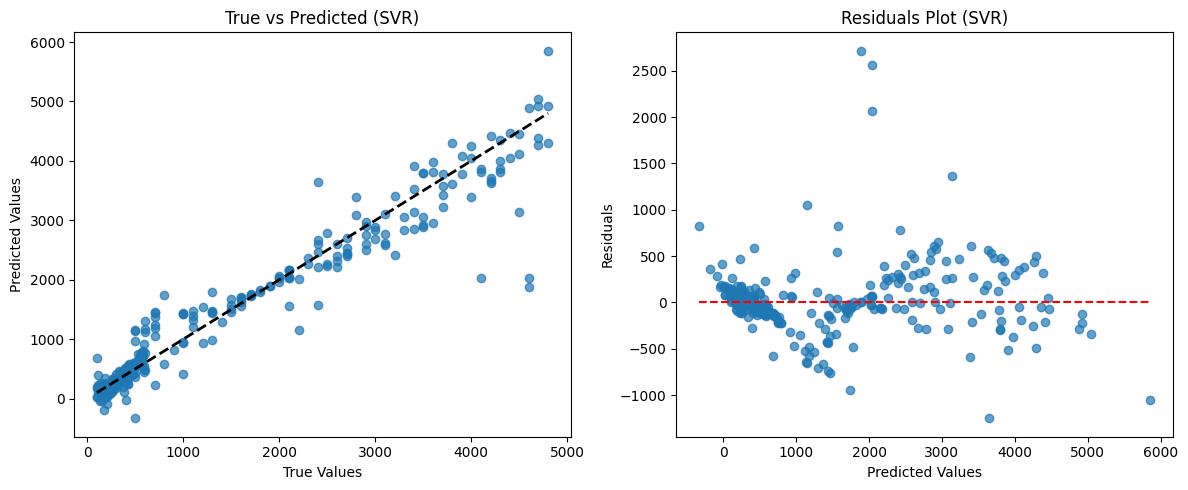

Training SVR for Max_GroupBy...
Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.8832038982368168
Mean Squared Error (MSE): 255895.1667
R² Score: 0.8537


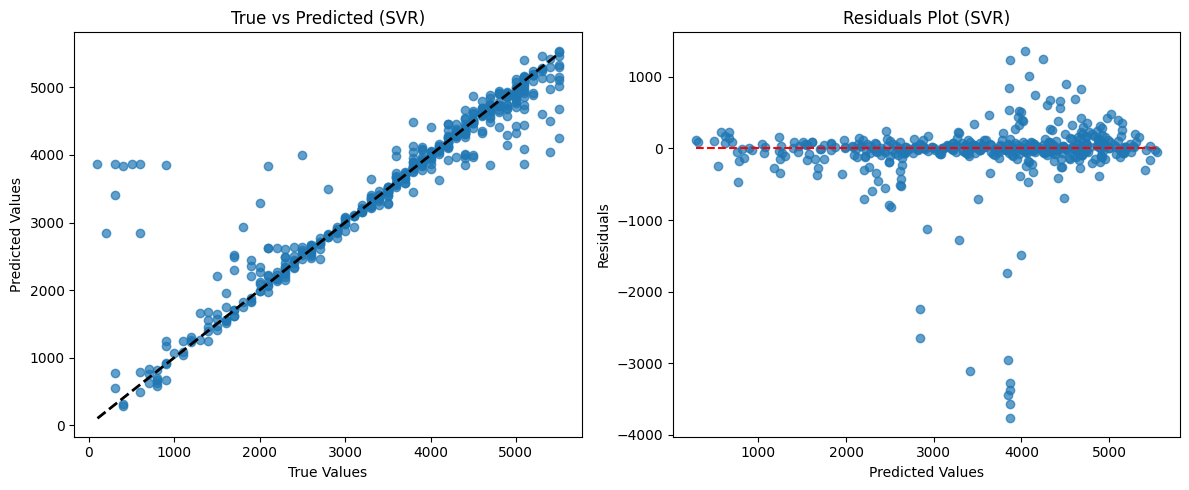

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.9184797529992741
Mean Squared Error (MSE): 248792.9761
R² Score: 0.9358


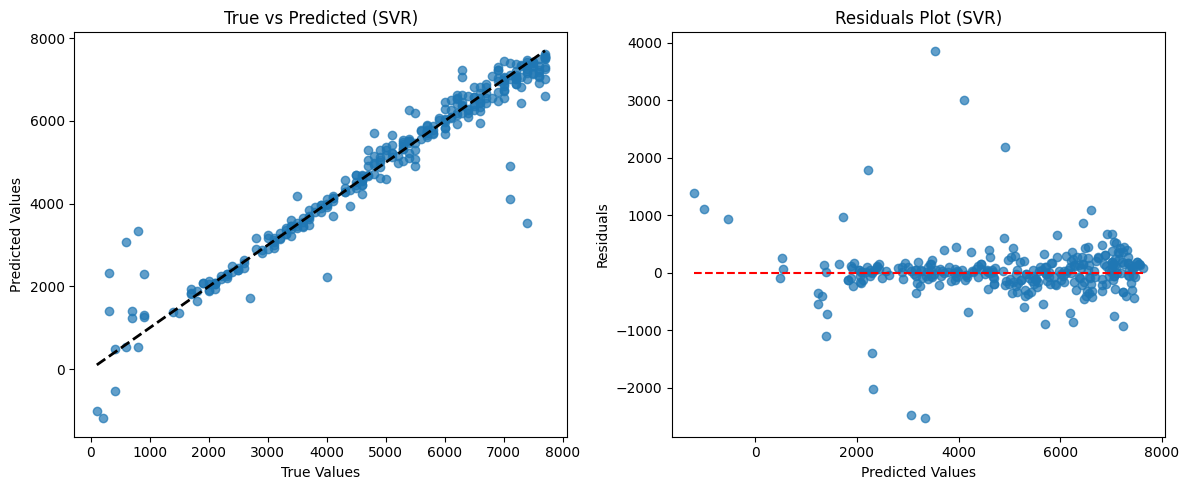

Training SVR for Avg_Partition...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
Best cross-validation score: 0.8650645503317737
Mean Squared Error (MSE): 112245.1680
R² Score: 0.8396


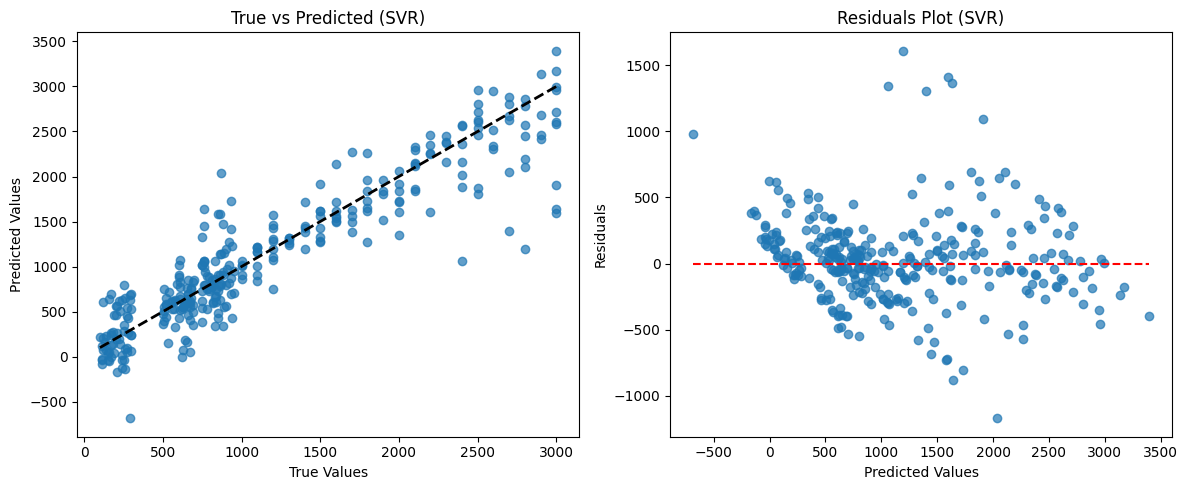

Training SVR for Count_By_Auction...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
Best cross-validation score: 0.947736850613134
Mean Squared Error (MSE): 73.6127
R² Score: 0.9585


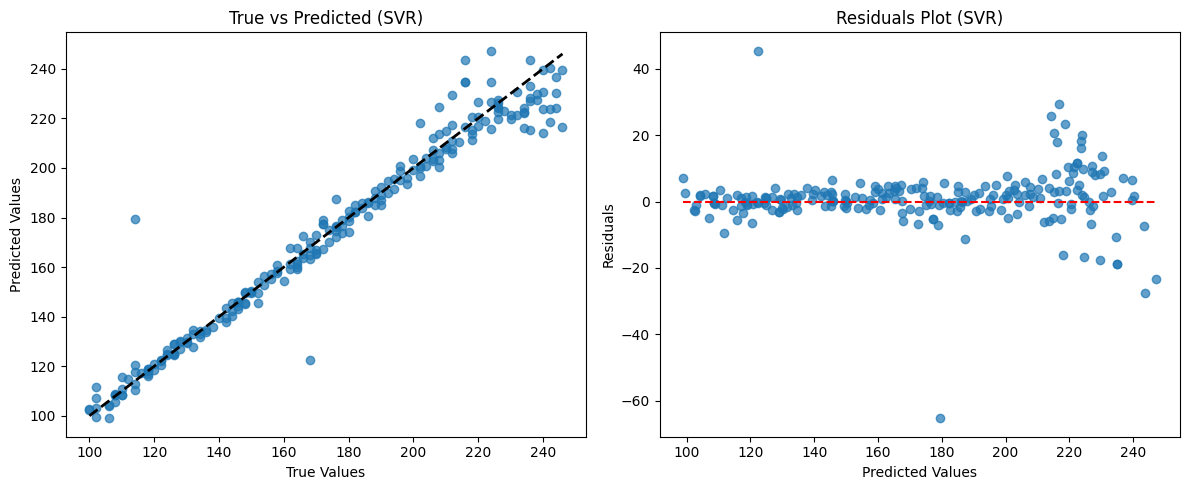

In [16]:
svr_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_window_models[operator]['model'], 
    svr_window_models[operator]['params'], 
    svr_window_models[operator]['scaler_x'], 
    svr_window_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

Training SVR for Join...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.24902124666185688
Mean Squared Error (MSE): 94179.3808
R² Score: -112.9975


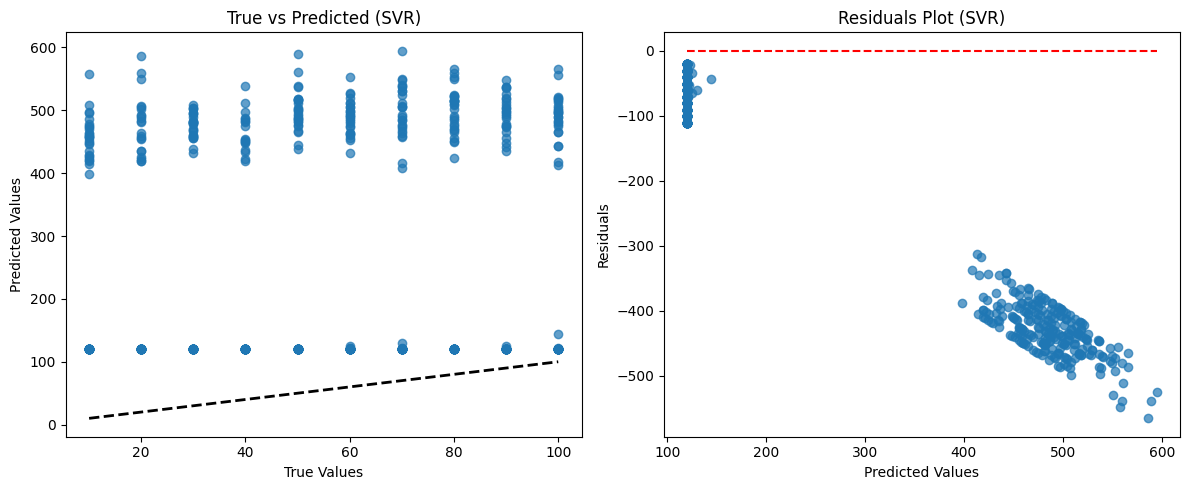

Training SVR for Max_GroupBy...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Best cross-validation score: 0.5184826647992749
Mean Squared Error (MSE): 553497.4629
R² Score: 0.3703


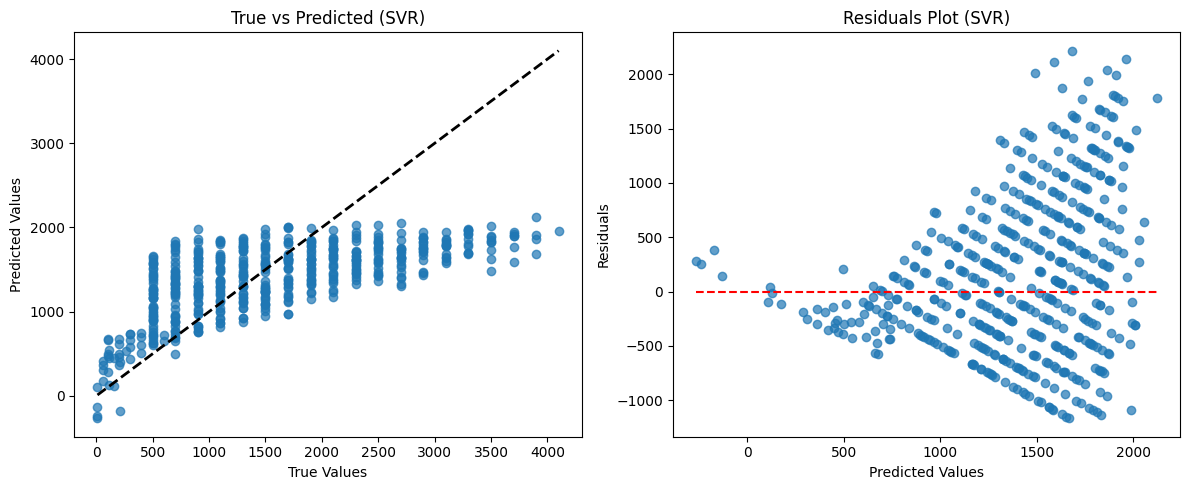

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.2144757954444861
Mean Squared Error (MSE): 1275000.6526
R² Score: 0.2376


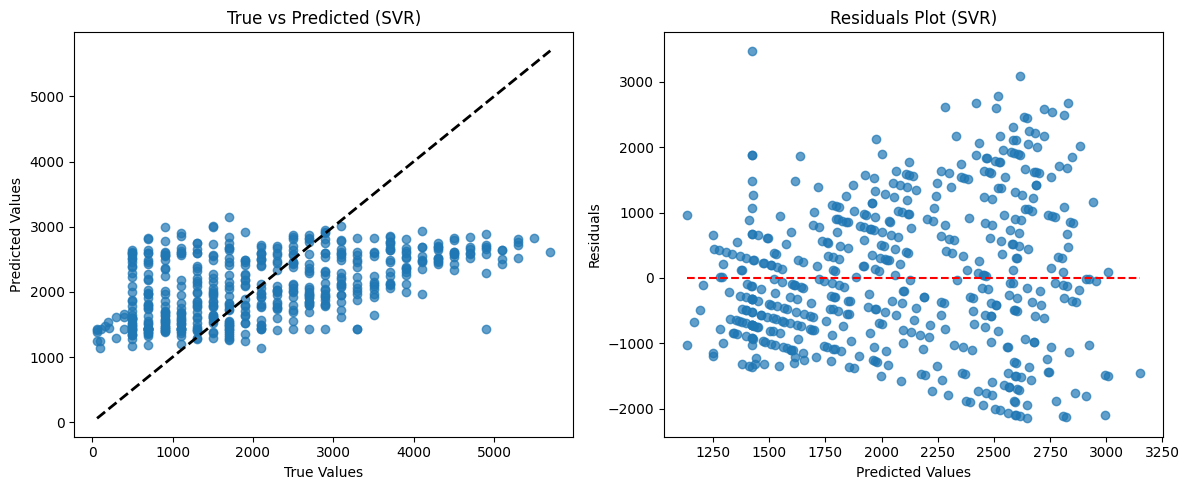

Training SVR for Avg_Partition...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Best cross-validation score: 0.5643404054281584
Mean Squared Error (MSE): 9779.5923
R² Score: 0.5529


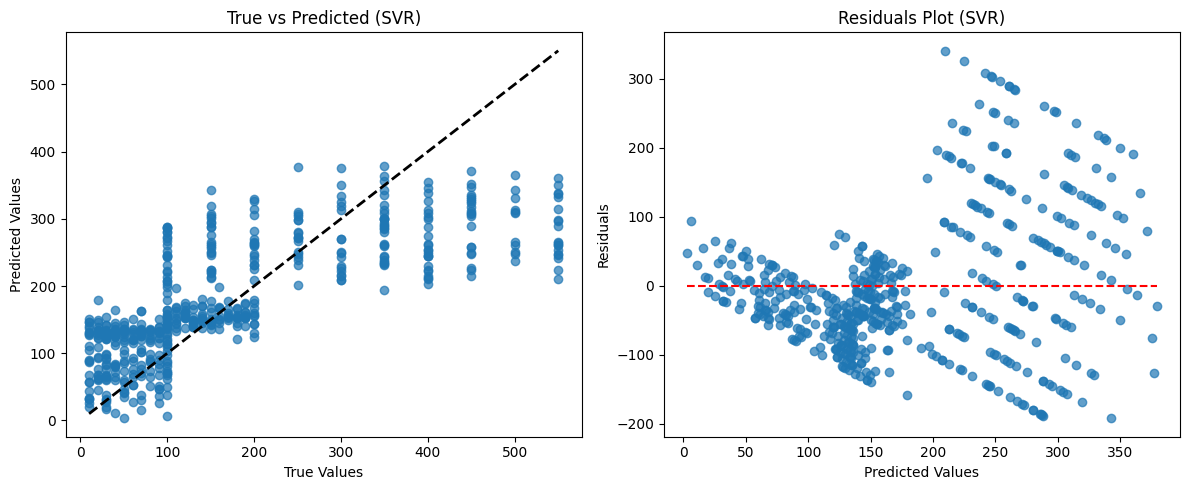

Training SVR for Count_By_Auction...
Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'auto'}
Best cross-validation score: 0.68666776808156
Mean Squared Error (MSE): 303.3223
R² Score: 0.6480


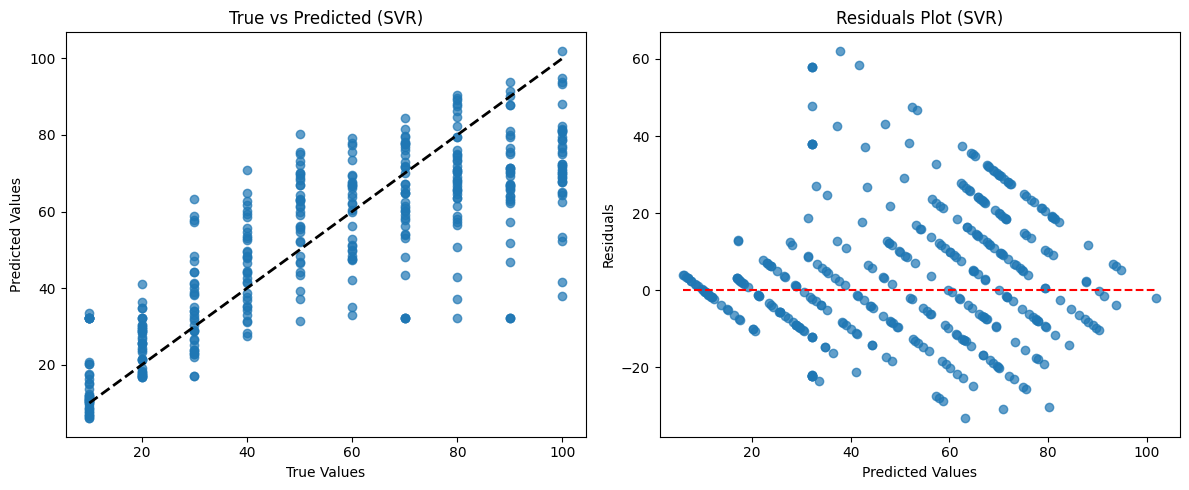

In [22]:
svr_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_sliding_step_models[operator]['model'], 
    svr_sliding_step_models[operator]['params'], 
    svr_sliding_step_models[operator]['scaler_x'], 
    svr_sliding_step_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

Training SVR for Join...
Mean Squared Error (MSE): 92315.0000
R² Score: -3.4300


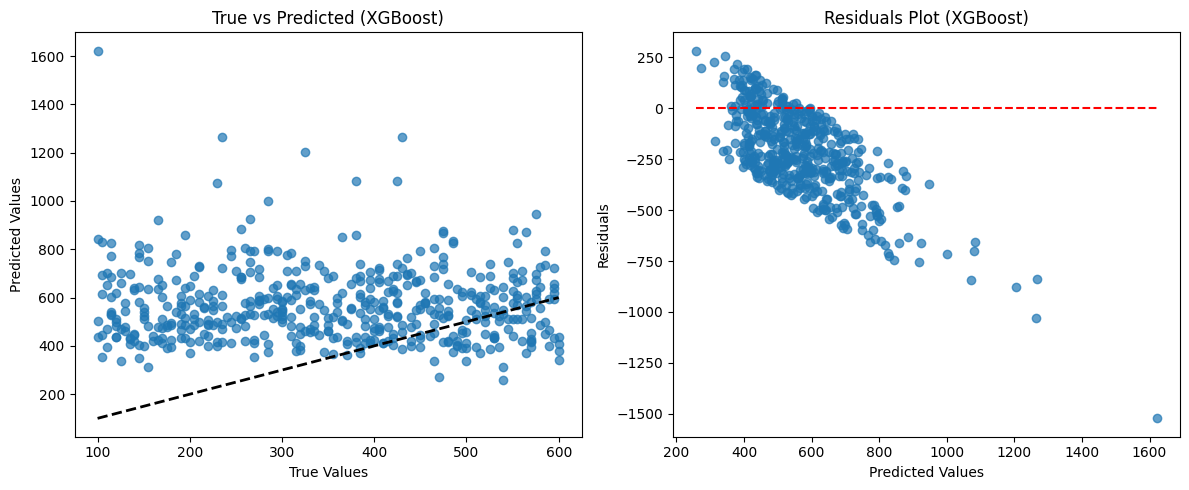

Training SVR for Max_GroupBy...
Mean Squared Error (MSE): 942437.3750
R² Score: 0.5408


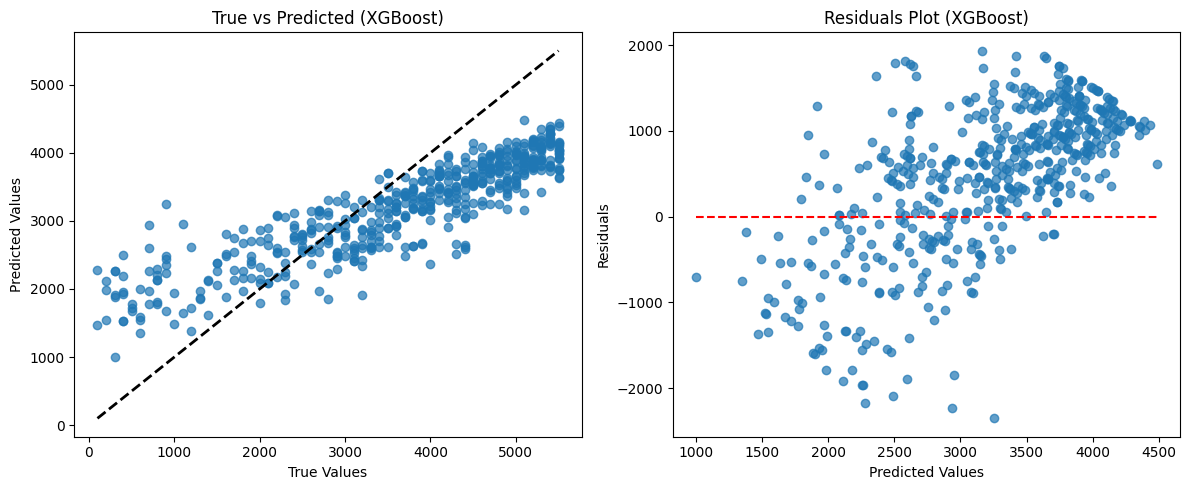

Training SVR for Avg_Sliding...
Mean Squared Error (MSE): 205295.5781
R² Score: 0.9421


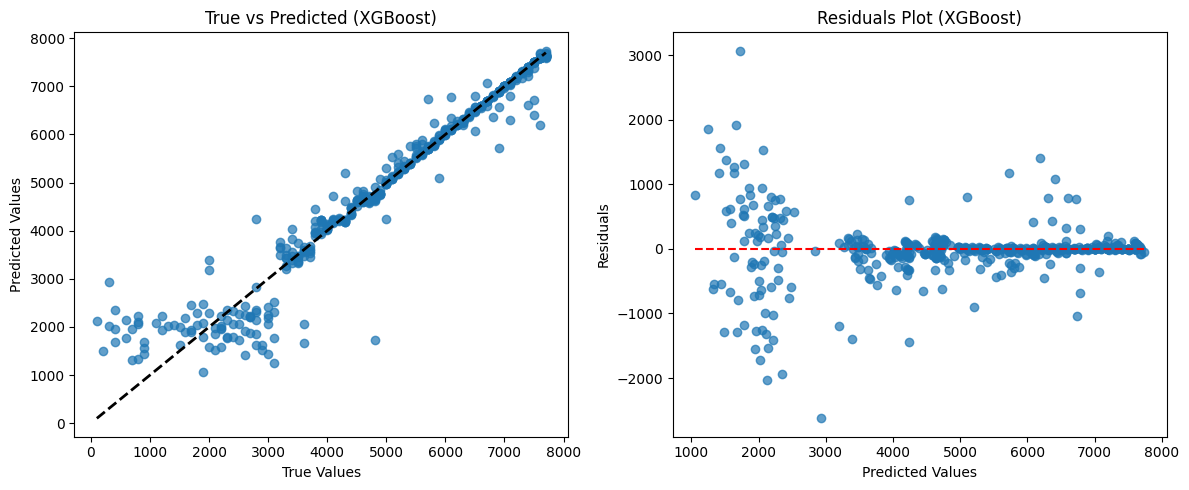

Training SVR for Avg_Partition...
Mean Squared Error (MSE): 171325.5469
R² Score: 0.7554


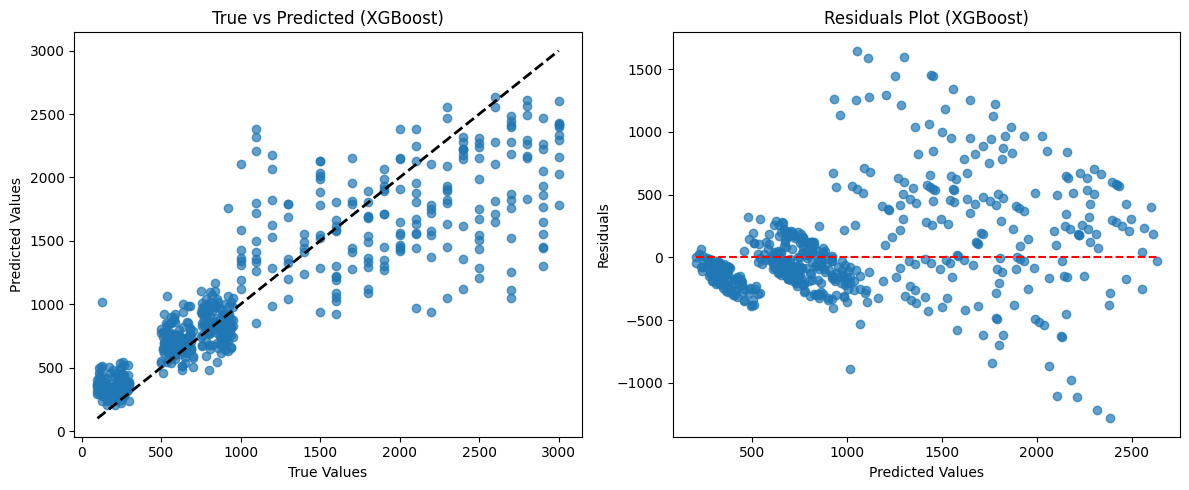

Training SVR for Count_By_Auction...
Mean Squared Error (MSE): 1980.6064
R² Score: -0.0951


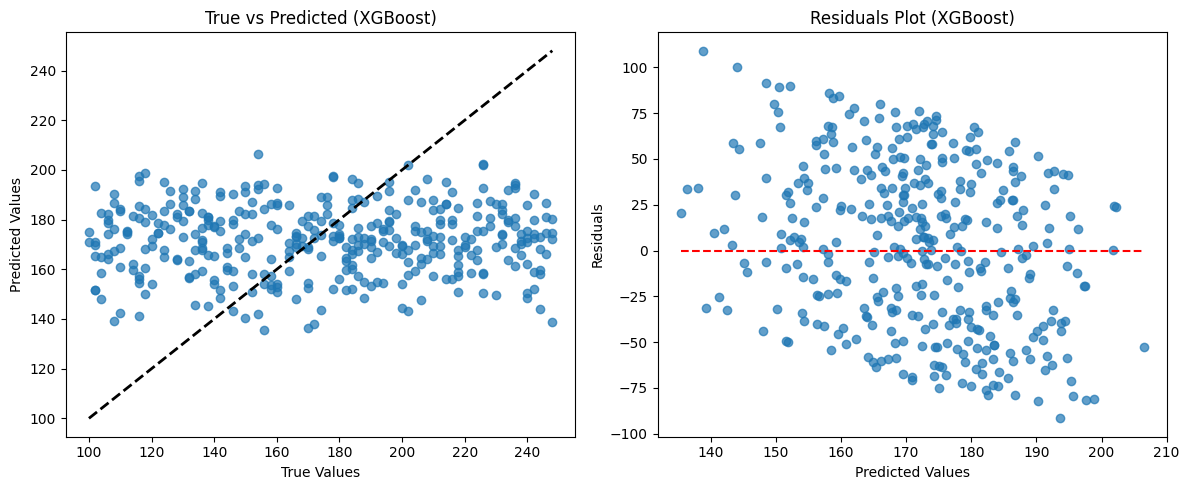

In [19]:
xgboost_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    xgboost_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgboost_window_models[operator]['model'], 
    xgboost_window_models[operator]['params'], 
    xgboost_window_models[operator]['scaler_x'], 
    xgboost_window_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

Training XGB for Join...
Mean Squared Error (MSE): 223250.0000
R² Score: -269.2285


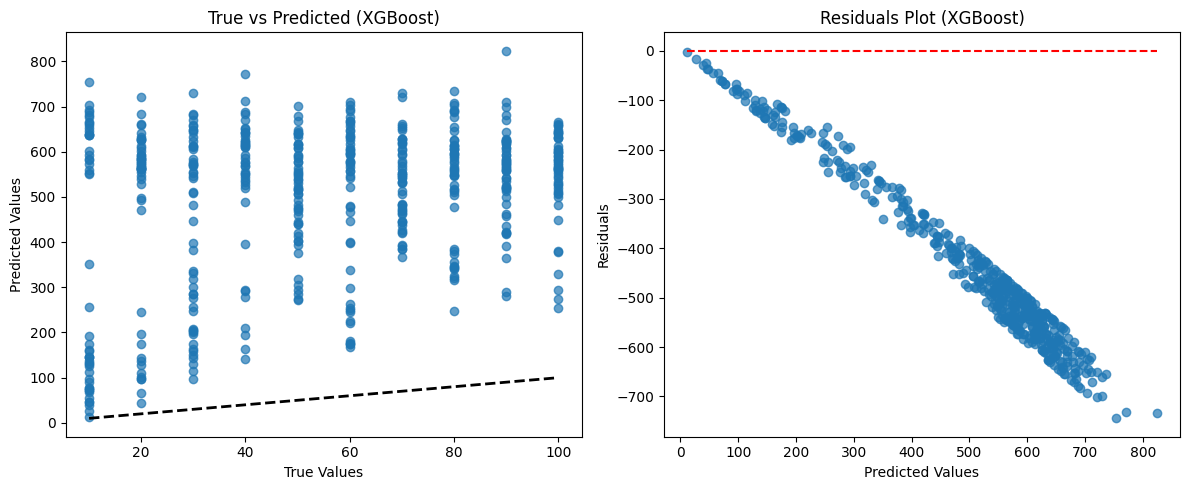

Training XGB for Max_GroupBy...
Mean Squared Error (MSE): 796866.3750
R² Score: 0.0934


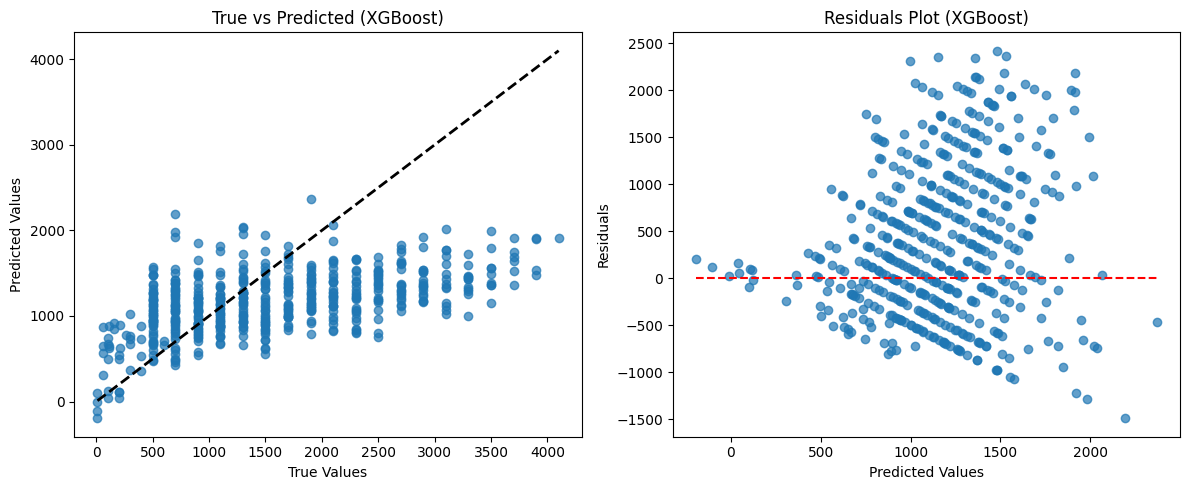

Training XGB for Avg_Sliding...
Mean Squared Error (MSE): 1350718.2500
R² Score: 0.1924


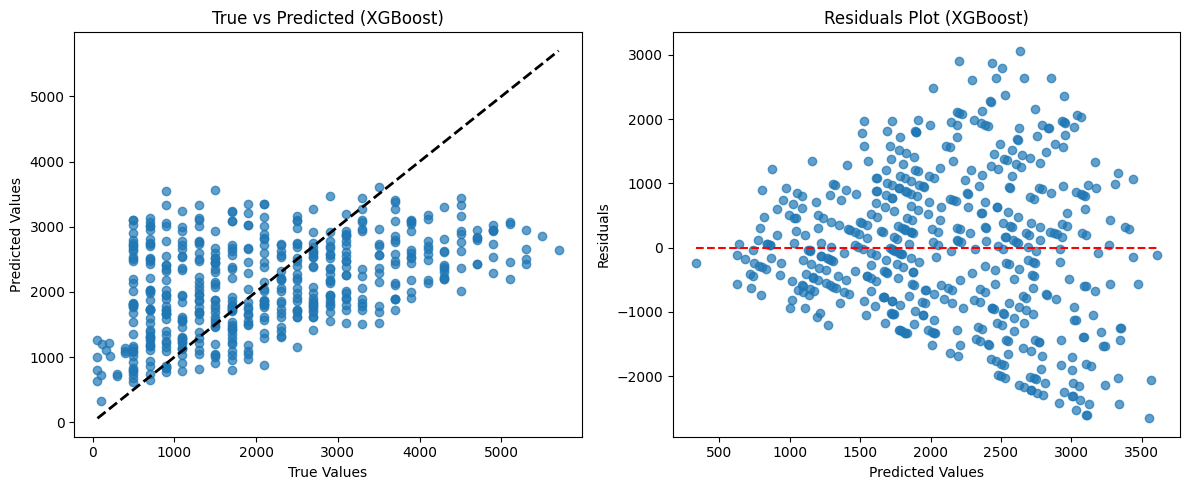

Training XGB for Avg_Partition...
Mean Squared Error (MSE): 11554.5938
R² Score: 0.4717


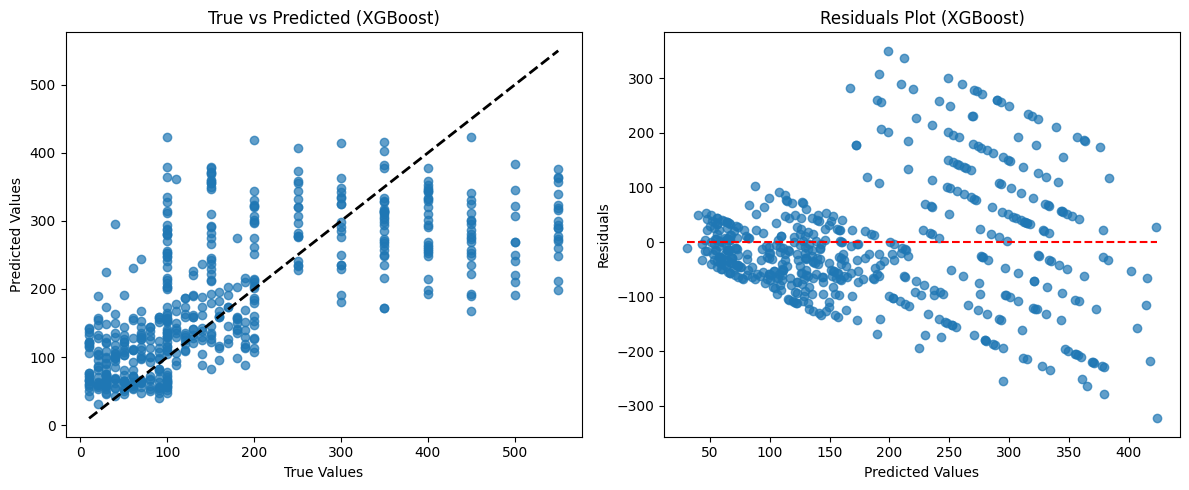

Training XGB for Count_By_Auction...
Mean Squared Error (MSE): 715.1257
R² Score: 0.1702


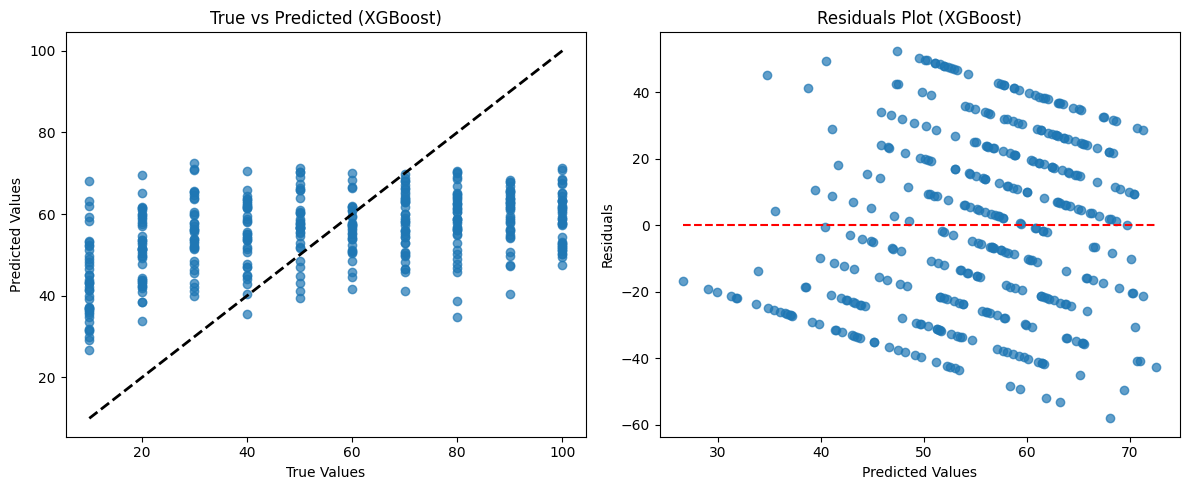

In [20]:
xgb_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training XGB for {operator}...")
    xgb_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgb_sliding_step_models[operator]['model'], 
    xgb_sliding_step_models[operator]['params'], 
    xgb_sliding_step_models[operator]['scaler_x'], 
    xgb_sliding_step_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

In [43]:
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
    # Scale the data (XGBoost works without scaling, but scaling sometimes still helps)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Train the XGBoost model
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        objective='reg:squarederror'  # important for regression
    )
    model.fit(X_train_scaled, y_train_scaled)
    
    # Predict
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot True vs Predicted
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted (XGBoost)')

    # Plot Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot (XGBoost)')
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler_X, scaler_y

Mean Squared Error (MSE): 165377.0312
R² Score: 0.9553


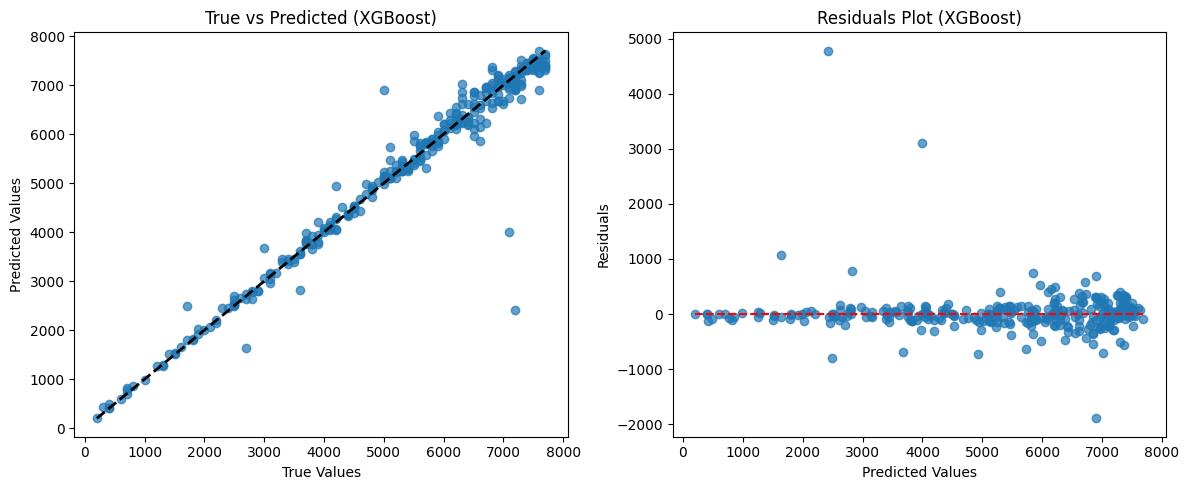

In [44]:
x_train = data_files[current_operator]['train_data']
y_train = data_files[current_operator]['train_window_time']
x_test = data_files[current_operator]['test_data']
y_test = data_files[current_operator]['test_window_time']

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

model_xgboost_window, xgboost_scaler_x_window, xgboost_scaler_y_window = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

Mean Squared Error (MSE): 7059.4380
R² Score: 0.9963


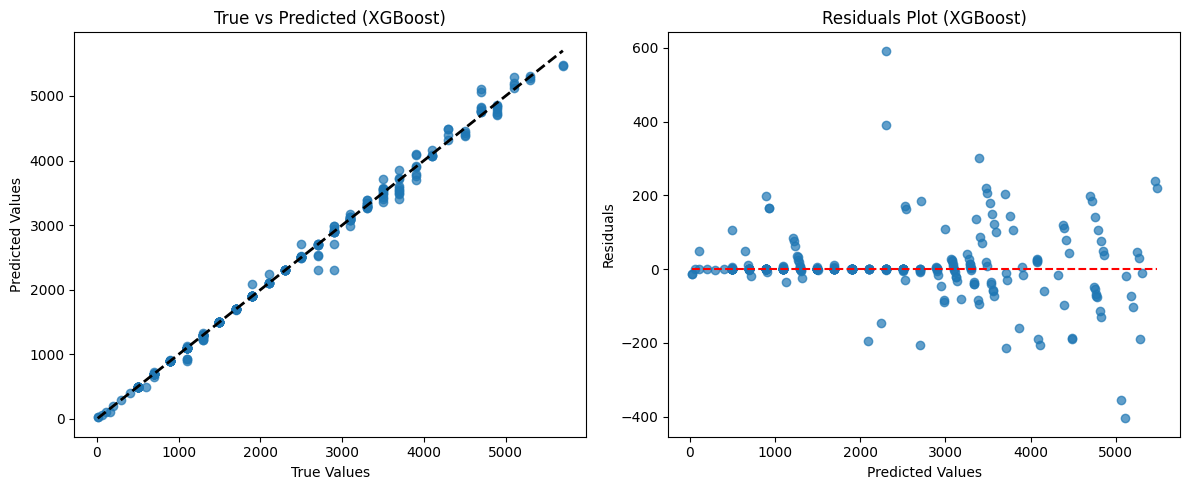

In [45]:
x_train = data_files[current_operator]['train_data']
y_train = data_files[current_operator]['train_sliding_step']
x_test = data_files[current_operator]['test_data']
y_test = data_files[current_operator]['test_sliding_step']

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

model_xgboost_sliding_step, xgboost_scaler_x_sliding_step, xgboost_scaler_y_sliding_step = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

In [52]:
def tune_xgb_hyperparameters_random(X_train, y_train, n_iter=20):
    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    # Define model
    model = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Define parameter distributions (notice slight differences here)
    param_distributions = {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3)
    }

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,  # number of random combinations to try
        scoring='r2',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train_scaled, y_train_scaled)

    print("Best Parameters Found:", random_search.best_params_)
    print("Best R² Score Found:", random_search.best_score_)

    return random_search.best_estimator_, scaler_X, scaler_y


In [58]:
x_train = data_files[current_operator]['train_data']
y_train = data_files[current_operator]['train_window_time']
x_test = data_files[current_operator]['test_data']
y_test = data_files[current_operator]['test_window_time']

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Random Search Tuning
best_model_random, scaler_X, scaler_y = tune_xgb_hyperparameters_random(x_train, y_train)

# Evaluate
X_test_scaled = scaler_X.transform(x_test)
y_pred_scaled = best_model_random.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters Found: {'colsample_bytree': np.float64(0.7842803529062142), 'learning_rate': np.float64(0.17280882494747454), 'max_depth': 3, 'n_estimators': 256, 'subsample': np.float64(0.9406590942262119)}
Best R² Score Found: 0.9771829181272408
Test MSE: 103038.7500
Test R²: 0.9721


In [53]:
x_train = data_files[current_operator]['train_data']
y_train = data_files[current_operator]['train_sliding_step']
x_test = data_files[current_operator]['test_data']
y_test = data_files[current_operator]['test_sliding_step']

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Random Search Tuning
best_model_random, scaler_X, scaler_y = tune_xgb_hyperparameters_random(x_train, y_train)

# Evaluate
X_test_scaled = scaler_X.transform(x_test)
y_pred_scaled = best_model_random.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters Found: {'colsample_bytree': np.float64(0.7842803529062142), 'learning_rate': np.float64(0.17280882494747454), 'max_depth': 3, 'n_estimators': 256, 'subsample': np.float64(0.9406590942262119)}
Best R² Score Found: 0.9942414144878701
Test MSE: 7025.2793
Test R²: 0.9963


In [20]:
secure_sgx_storage = {
    'reduce': {
        'dirs': [
            '/home/hungpm/Work/LeackyStream/leaky-dataset/secure_sgx/reduce',
        ],
        'label': 4
    },
}

In [21]:
secure_sgx_files = {}
for operator in secure_sgx_storage:
    secure_sgx_files[operator] = {
        'files': [],
        'label': secure_sgx_storage[operator]['label']
    }

    for dir in secure_sgx_storage[operator]['dirs']:
        files = [f for f in os.listdir(dir) if f.endswith('.csv')]
        secure_sgx_files[operator]['files'].extend([os.path.join(dir, file) for file in files])

In [22]:
sgx_operator = 'reduce'
sgx_substring = 'tail_0'

In [23]:
secure_sgx_files[sgx_operator]['data'] = load_dataset(secure_sgx_files[sgx_operator]['files'])

Minimum length of data: 93221
Number of files with less than 512 samples: 0


In [24]:
secure_sgx_files[sgx_operator]['files'][0]

'/home/hungpm/Work/LeackyStream/leaky-dataset/secure_sgx/reduce/tail_0_600_400.csv'

In [25]:
secure_sgx_files[sgx_operator]['window_time'] = []
secure_sgx_files[sgx_operator]['sliding_step'] = []
for file in secure_sgx_files[sgx_operator]['files']:
    window_start_index = file.index(substring) + len(substring) + 1
    window_time = file[window_start_index:file.index('_', window_start_index)]
    secure_sgx_files[sgx_operator]['window_time'].append(int(window_time))
    sliding_step = file[file.index('_', window_start_index) + 1:file.rindex('.', window_start_index)]
    secure_sgx_files[sgx_operator]['sliding_step'].append(int(sliding_step))
    # print(f"Window time: {window_time}, Sliding step: {sliding_step}")
    # break

In [26]:
def evaluate_model(model, x_test, y_test, scaler_X=None, scaler_y=None):
    # Scale the data if scalers are provided
    if scaler_X is not None:
        x_test = scaler_X.transform(x_test)

    # Predict
    y_pred = model.predict(x_test)

    # Inverse transform if scaler_y is provided
    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Plot True vs Predicted
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted')

    # Plot Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    
    plt.tight_layout()

Mean Squared Error (MSE): 1399032.4193
R² Score: 0.1820


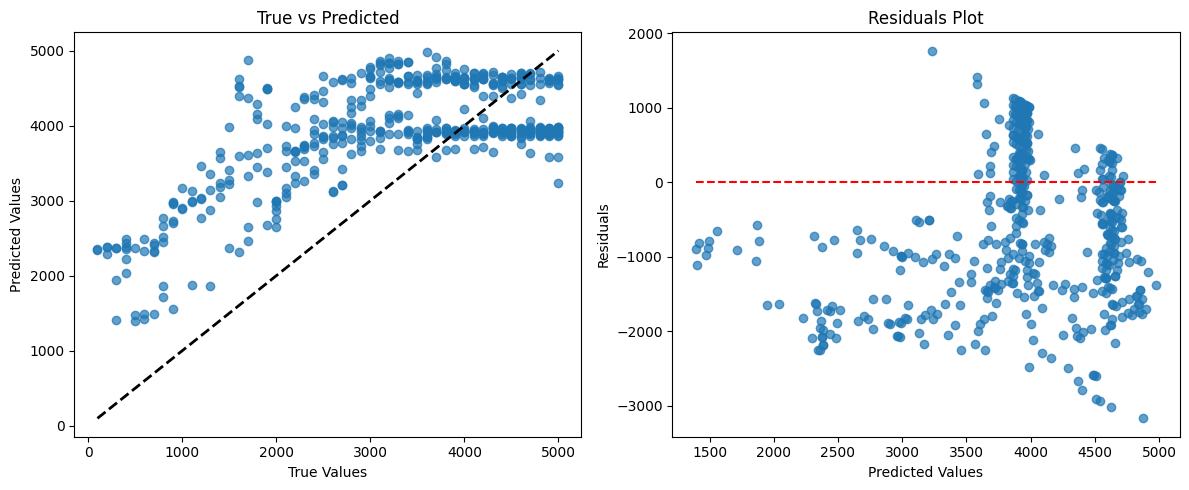

In [33]:
sgx_x = secure_sgx_files[sgx_operator]['data']
sgx_y = secure_sgx_files[sgx_operator]['window_time']

# Convert to numpy arrays
sgx_x = np.array(sgx_x)
sgx_y = np.array(sgx_y)

evaluate_model(rf_window_models['Max_GroupBy'], sgx_x, sgx_y)

Mean Squared Error (MSE): 7747553.1646
R² Score: -8.8669


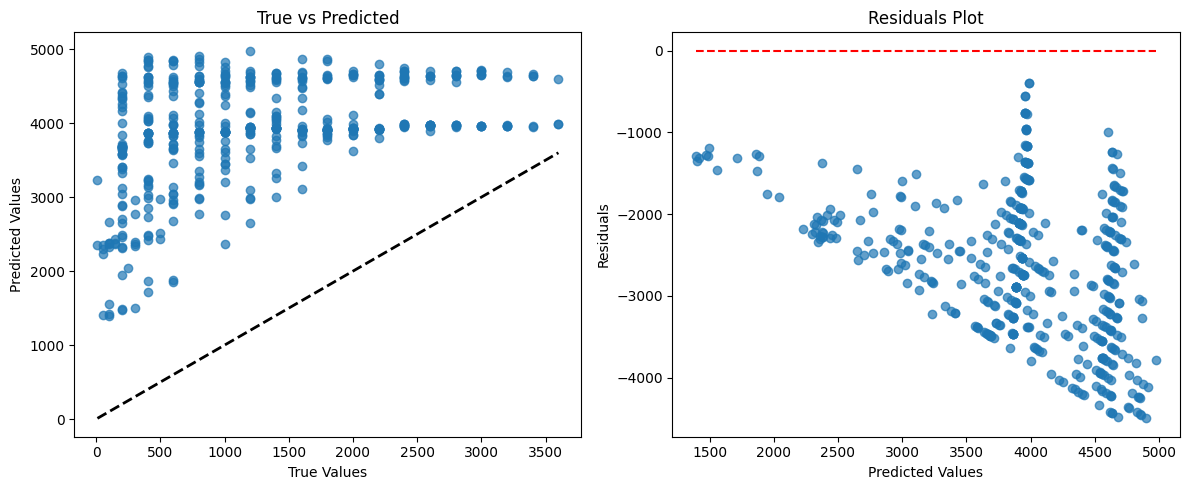

In [34]:
sgx_x = secure_sgx_files[sgx_operator]['data']
sgx_y = secure_sgx_files[sgx_operator]['sliding_step']

# Convert to numpy arrays
sgx_x = np.array(sgx_x)
sgx_y = np.array(sgx_y)

evaluate_model(rf_window_models['Max_GroupBy'], sgx_x, sgx_y)

Mean Squared Error (MSE): 6730460.6162
R² Score: -2.9352


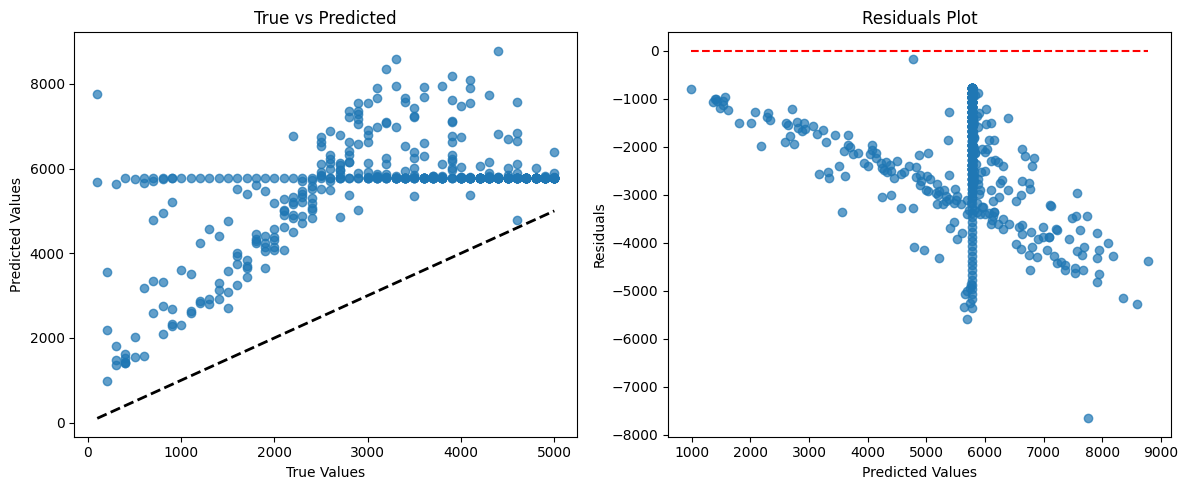

In [56]:
evaluate_model(model_svr_window, sgx_x, sgx_y, scaler_X=svr_scaler_x_window, scaler_y=svr_scaler_y_window)

Mean Squared Error (MSE): 8852237.0000
R² Score: -4.1758


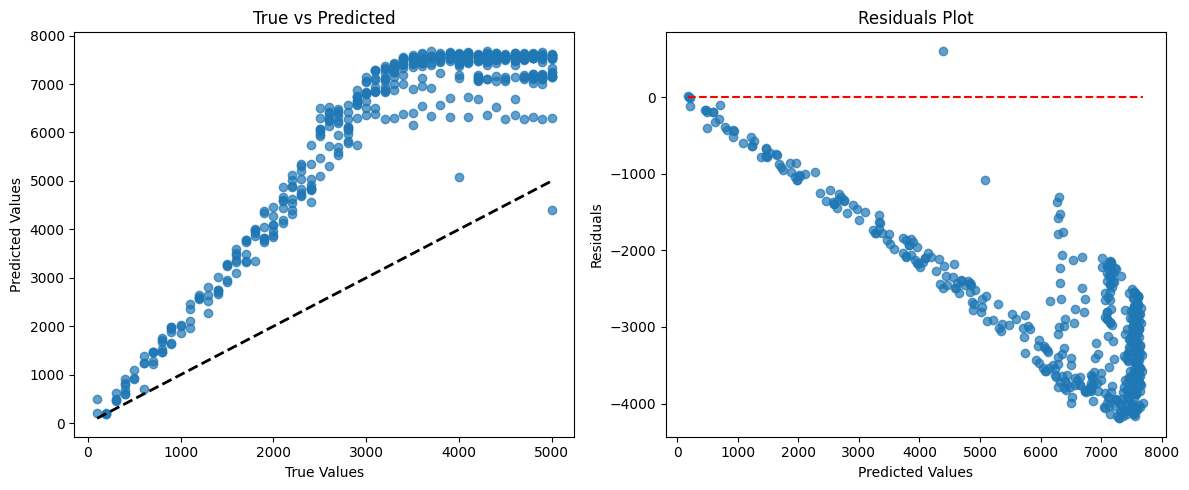

In [57]:
evaluate_model(model_xgboost_window, sgx_x, sgx_y, scaler_X=xgboost_scaler_x_window, scaler_y=xgboost_scaler_y_window)

Mean Squared Error (MSE): 9713015.0000
R² Score: -4.6791


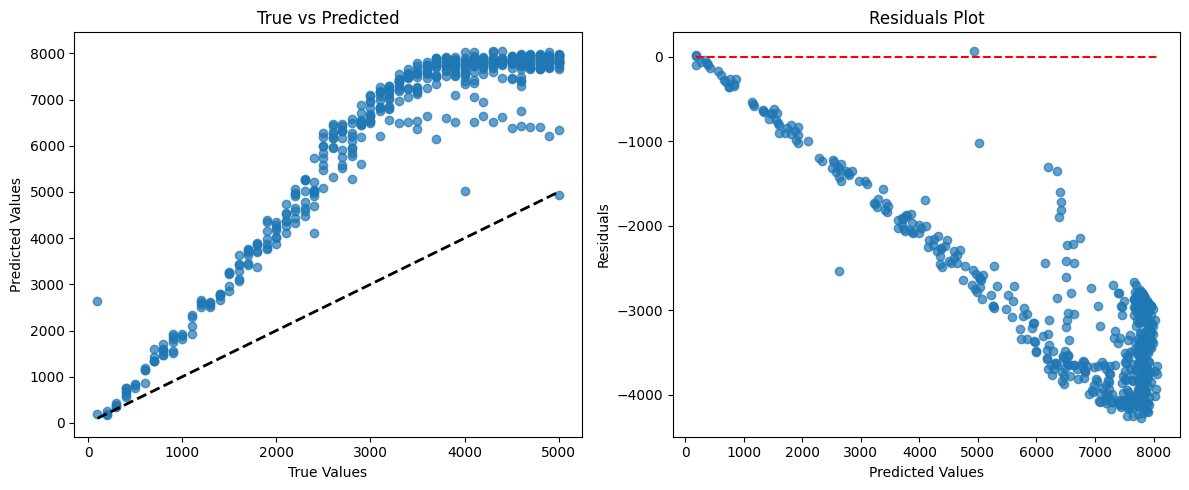

In [60]:
evaluate_model(best_model_random, sgx_x, sgx_y, scaler_X=scaler_X, scaler_y=scaler_y)

Mean Squared Error (MSE): 66837.2062
R² Score: 0.9149


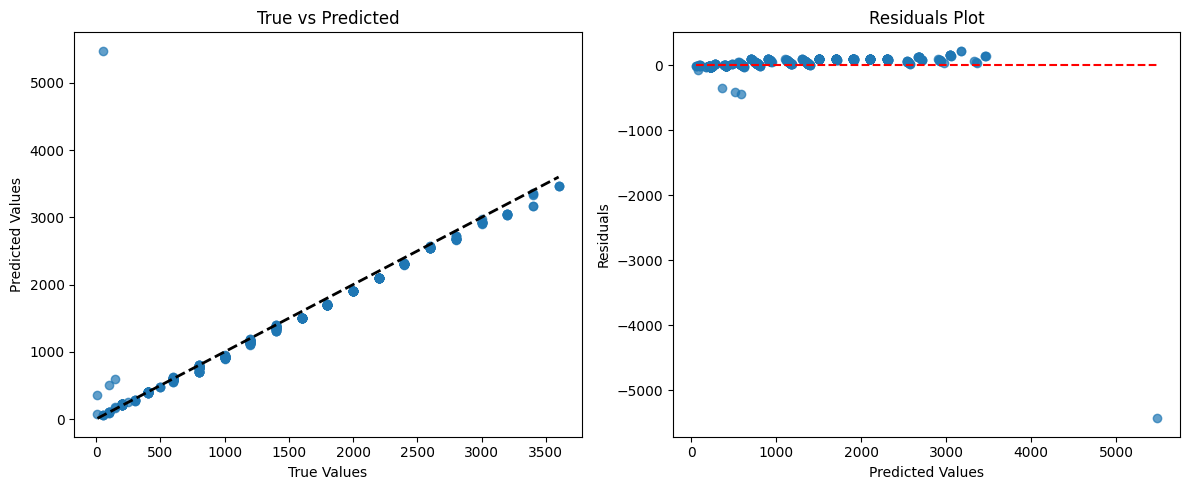

In [48]:
sgx_x = secure_sgx_files[sgx_operator]['data']
sgx_y = secure_sgx_files[sgx_operator]['sliding_step']

# Convert to numpy arrays
sgx_x = np.array(sgx_x)
sgx_y = np.array(sgx_y)

evaluate_model(model_rf_sliding_step, sgx_x, sgx_y)

Mean Squared Error (MSE): 0.4453
R² Score: 0.0770


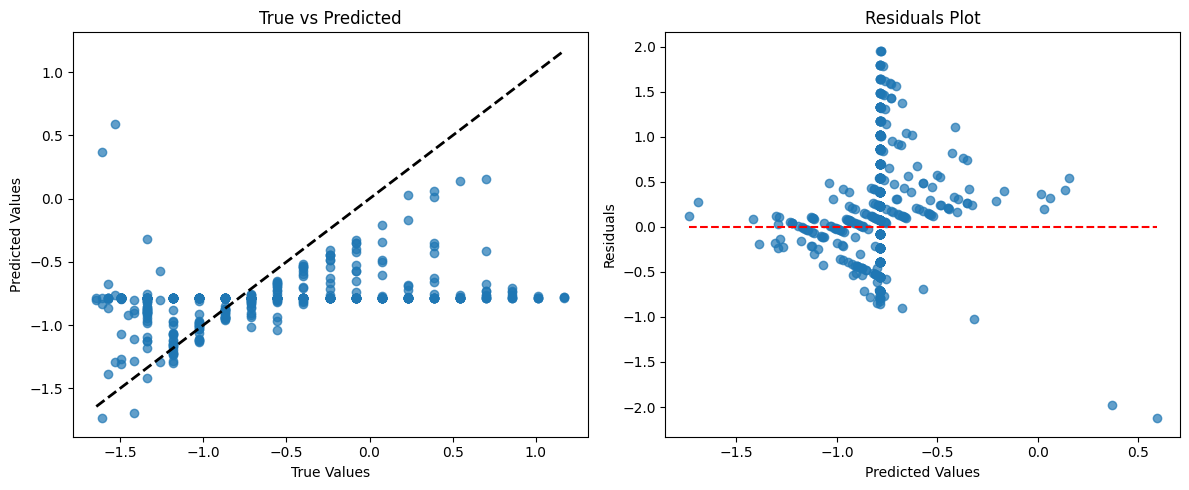

In [49]:
sgx_y_scaled = svr_scaler_y_sliding_step.transform(sgx_y.reshape(-1, 1)).ravel()
sgx_x_scaled = svr_scaler_x_sliding_step.transform(sgx_x)
evaluate_model(model_svr_sliding_step, sgx_x_scaled, sgx_y_scaled)

Mean Squared Error (MSE): 0.0414
R² Score: 0.9141


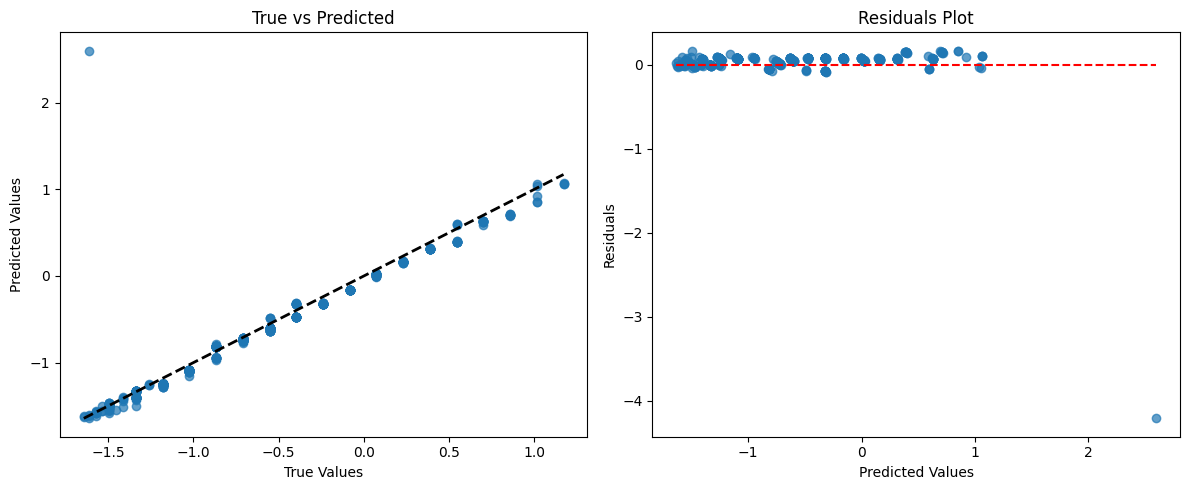

In [50]:
sgx_x_scaled = xgboost_scaler_x_sliding_step.transform(sgx_x)
sgx_y_scaled = xgboost_scaler_y_sliding_step.transform(sgx_y.reshape(-1, 1)).ravel()
evaluate_model(model_xgboost_sliding_step, sgx_x_scaled, sgx_y_scaled)

In [ ]:
secure_sgx_dataset = {
    'files': [],
    'label': np.array([]),
    'cdf': []
}

for operator in secure_sgx_files:
    secure_sgx_dataset['files'] = np.concatenate((secure_sgx_dataset['files'], secure_sgx_files[operator]['files']))
    # secure_sgx_dataset['label'] = np.concatenate((secure_sgx_dataset['label'], [secure_sgx_files[operator]['label']] * len(secure_sgx_files[operator]['files'])))
    secure_sgx_dataset['cdf'].extend(load_dataset(secure_sgx_files[operator]['files']))

secure_sgx_dataset['cdf'] = np.array(secure_sgx_dataset['cdf'])


Minimum length of data: 111
Number of files with less than 512 samples: 2
Minimum length of data: 99994
Number of files with less than 512 samples: 0
Minimum length of data: 93221
Number of files with less than 512 samples: 0


Classification Report:
               precision    recall  f1-score   support

          Map       0.52      0.89      0.66       380
       Filter       0.48      0.11      0.18       352
         Join       0.00      0.00      0.00         0
  Max_GroupBy       0.00      0.00      0.00         0
  Avg_Sliding       0.99      0.77      0.87       483
Avg_Partition       0.00      0.00      0.00         0

     accuracy                           0.62      1215
    macro avg       0.33      0.30      0.28      1215
 weighted avg       0.70      0.62      0.60      1215

Confusion Matrix:
[[339  38   0   2   1   0]
 [312  39   0   0   1   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  2   4   8  93 374   2]
 [  0   0   0   0   0   0]]


/home/hungpm/Work/LeackyStream/leacky_classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hungpm/Work/LeackyStream/leacky_classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hungpm/Work/LeackyStream/leacky_classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

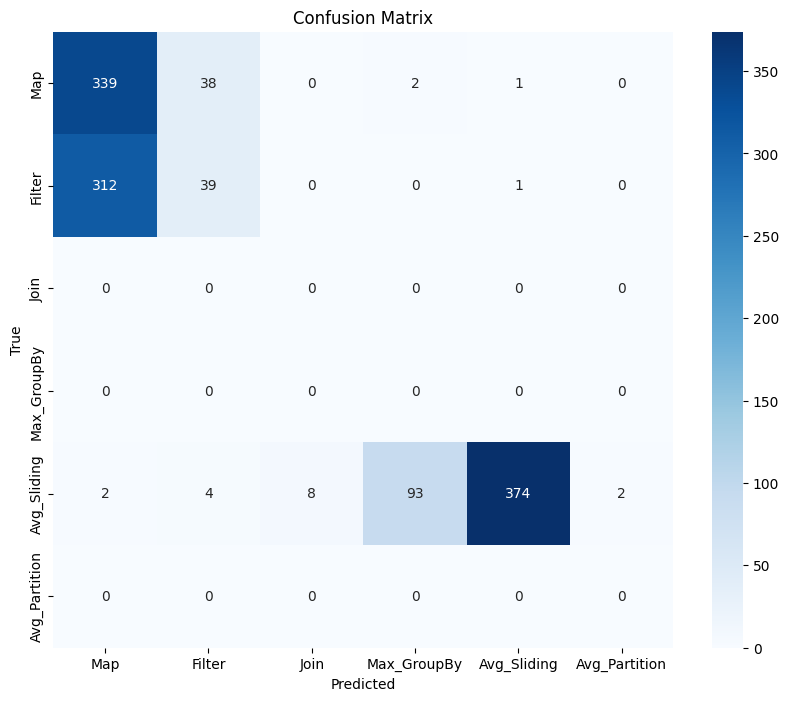

/home/hungpm/Work/LeackyStream/leacky_classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/hungpm/Work/LeackyStream/leacky_classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


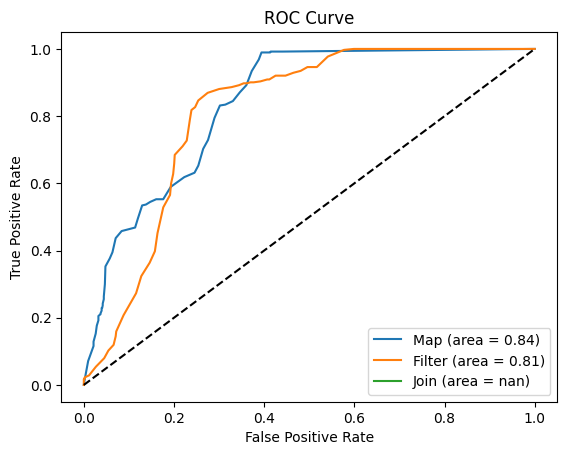

In [23]:
# Extract features and labels from secure_sgx_dataset
X_secure_sgx = secure_sgx_dataset['cdf']
y_secure_sgx = secure_sgx_dataset['label']

# Predict using the trained Random Forest model
y_pred = model_rf.predict(X_secure_sgx)
y_score = model_rf.predict_proba(X_secure_sgx)

# Classification report
print("Classification Report:")
print(classification_report(y_secure_sgx, y_pred, target_names=class_names[:len(np.unique(y_pred))]))

# Confusion matrix
cm = confusion_matrix(y_secure_sgx, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names[:len(np.unique(y_pred))], 
            yticklabels=class_names[:len(np.unique(y_pred))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure()
for i in range(len(np.unique(y_secure_sgx))):
    fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_secure_sgx], y_score[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_secure_sgx], y_score[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Training Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1009
           1       0.83      0.38      0.52      1037
           2       0.97      0.90      0.94       808
           3       0.70      0.95      0.81      1284
           4       0.70      0.64      0.67       812

    accuracy                           0.77      4950
   macro avg       0.79      0.76      0.75      4950
weighted avg       0.78      0.77      0.75      4950

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       253
           1       0.84      0.38      0.52       260
           2       0.99      0.93      0.96       202
           3       0.69      0.95      0.80       322
           4       0.71      0.61      0.66       204

    accuracy                           0.77      1241
   macro avg       0.80      0.76      0.75      1241
weighted avg     

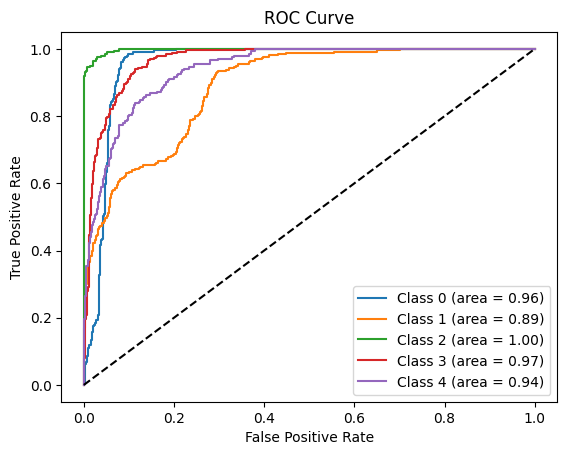

In [23]:
model_svm = SVC(probability=True)
train_and_evaluate(model_svm, train_set, train_labels, test_set, test_labels)

In [ ]:
# class TimeSeriesDataset(Dataset):
#     def __init__(self, files, label_dict):
#         self.label_dict = label_dict
#         self.files = files
#         self.labels = []

#         self.data = []
#         for idx, file_path in enumerate(self.files):
#             data_raw = pd.read_csv(file_path).values.astype(np.float32)
#             if len(data_raw[:, 1]) == 0:
#                 print(f"Warning: No data in {file_path}")
#                 continue
#             cdf_features = calculate_cdf(data_raw[:, 1])
#             self.data.append(cdf_features)
#             self.labels.append(self.label_dict[idx])

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, files, data, label_dict):
        self.label_dict = label_dict
        self.files = files
        self.labels = label_dict
        self.data = data
        # for idx, file_path in enumerate(self.files):
        #     data_raw = pd.read_csv(file_path).values.astype(np.float32)
        #     if len(data_raw[:, 1]) == 0:
        #         print(f"Warning: No data in {file_path}")
        #         continue
        #     cdf_features = calculate_cdf(data_raw[:, 1])
        #     self.data.append(cdf_features)
        #     self.labels.append(self.label_dict[idx])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [25]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [26]:
def evaluate_nn(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy


In [27]:
def train_nn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss, val_acc = evaluate_nn(model, val_loader, criterion, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

In [43]:
for operator in data_files:
    val, test = train_test_split(data_files[operator]['test'], train_size=0.5, shuffle=True, random_state=42)
    data_files[operator]['val'] = val
    data_files[operator]['test_2'] = test

In [44]:
# train_files = []
val_files = []
test_files_2 = []

# train_labels = []
val_labels = []
test_labels_2 = []

for operator in data_files:
    # train_files.extend(data_files[operator]['train'])
    # train_labels.extend([data_files[operator]['label']]*len(data_files[operator]['train']))

    val_files.extend(data_files[operator]['val'])
    # val_labels.extend([data_files[operator]['label']]*len(data_files[operator]['val']))

    test_files_2.extend(data_files[operator]['test_2'])
    # test_labels_2.extend([data_files[operator]['label']]*len(data_files[operator]['test_2']))

In [45]:
val_set = []
test_set_2 = []

for file, data, label in zip(test_files, test_set, test_labels):
    if file in test_files_2:
        test_set_2.append(data)
        test_labels_2.append(label)
    else:
        val_set.append(data)
        val_labels.append(label)

val_set = np.array(val_set)
test_set_2 = np.array(test_set_2)

In [46]:
train_time_series_set = TimeSeriesDataset(train_files, train_set, train_labels)
val_time_series_set = TimeSeriesDataset(val_files, val_set, val_labels)
test_time_series_set = TimeSeriesDataset(test_files_2, test_set_2, test_labels_2)

In [47]:
train_loader = DataLoader(train_time_series_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_time_series_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_time_series_set, batch_size=16, shuffle=False)

In [42]:
len(test_labels_2)

2410

In [33]:
device = torch.device("cpu")

In [48]:
input_size = 1024  # Number of features after CDF calculation 
num_classes = 7

model = SimpleNN(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
train_nn(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20)

Epoch [1/20], Loss: 1.8104, Val Loss: 1.5508, Val Acc: 37.7186
Epoch [2/20], Loss: 1.3458, Val Loss: 1.3715, Val Acc: 47.2939
Epoch [3/20], Loss: 1.2546, Val Loss: 1.2687, Val Acc: 53.1224
Epoch [4/20], Loss: 1.2468, Val Loss: 1.2689, Val Acc: 53.9550
Epoch [5/20], Loss: 1.2097, Val Loss: 1.2208, Val Acc: 56.7860
Epoch [6/20], Loss: 1.1801, Val Loss: 1.1844, Val Acc: 56.5362
Epoch [7/20], Loss: 1.1769, Val Loss: 1.4444, Val Acc: 39.3838
Epoch [8/20], Loss: 1.1557, Val Loss: 1.2504, Val Acc: 51.9567
Epoch [9/20], Loss: 1.1538, Val Loss: 1.1922, Val Acc: 54.7044
Epoch [10/20], Loss: 1.1521, Val Loss: 1.2250, Val Acc: 50.7077
Epoch [11/20], Loss: 1.1464, Val Loss: 1.1195, Val Acc: 57.4521
Epoch [12/20], Loss: 1.1289, Val Loss: 1.1144, Val Acc: 56.2864
Epoch [13/20], Loss: 1.1173, Val Loss: 1.5270, Val Acc: 40.3830
Epoch [14/20], Loss: 1.1192, Val Loss: 1.1353, Val Acc: 55.7036
Epoch [15/20], Loss: 1.1031, Val Loss: 1.1344, Val Acc: 54.3714
Epoch [16/20], Loss: 1.1166, Val Loss: 1.0974, Va

In [43]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
_, test_acc = evaluate_nn(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:.2f}%')


Test Accuracy: 58.33%


In [51]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [60]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
train_set_scaled = min_max_scaler.fit_transform(train_set)
val_set_scaled = min_max_scaler.transform(val_set)
test_set_scaled = min_max_scaler.transform(test_set_2)

In [1]:
# Define a custom dataset class for our time series data
class TimeSeriesDatasetCNN(Dataset):
    def __init__(self, files, data, labels):
        self.files = files
        self.labels = labels
        self.data = data
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        data = self.data[idx]

        # Reshape for CNN input: [channels, sequence_length]
        data = data.reshape(1, -1)
            
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

NameError: name 'Dataset' is not defined

In [75]:
# Define the CNN model
class TimeSeriesCNN(nn.Module):
    def __init__(self, num_classes):
        super(TimeSeriesCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Adaptive pooling to ensure fixed size regardless of input
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Apply adaptive pooling and flatten
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc(x)
        return x

In [76]:
# Training function
def train_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0.0
    best_model_state = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f'New best model with validation accuracy: {best_val_acc:.4f}')
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, history

In [77]:
# Evaluation function
def evaluate_cnn(model, test_loader, criterion, device, class_names):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            
            # Save predictions and labels for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    return test_acc, cm

In [78]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()